Sample Notebook for Testing Dask Distributed on Cheyenne
====

by Joe Hamman, 2017-08-29


For this example, we'll open a 5 member ensemble of precipitation and temperature data. Each ensemble member is stored in a seperate netCDF file and are otherwise formatted identically.

In [9]:
%matplotlib inline

import xarray as xr
import matplotlib.pyplot as plt

# from dask.dot import dot_graph
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [10]:
from dask.distributed import Client
client = Client(scheduler_file='scheduler.json')
client

Client Scheduler: tcp://10.148.14.202:8786 Dashboard: http://10.148.14.202:8787,Cluster Workers: 47 Cores: 282 Memory: 1034.00 GB


### Open an Xarray Dataset

In [11]:
ds = xr.open_mfdataset('/glade/u/home/jhamman/workdir/GARD_inputs/newman_ensemble/conus_ens_0*',
                       engine='netcdf4', concat_dim='ensemble', chunks={'time': 50})

#### Metadata
let's start by printing some metadata before we get started with the fun


In [12]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds.info()

ds size in GB 4961.43

xarray.Dataset {
dimensions:
	ensemble = 99 ;
	lat = 224 ;
	lon = 464 ;
	time = 12054 ;

variables:
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:standard_name = latitude ;
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:standard_name = latitude ;
	float64 elevation(ensemble, lat, lon) ;
		elevation:units = meters ;
		elevation:long_name = Terrain Elevation ;
		elevation:standard_name = elevation ;
	float64 pcp(ensemble, time, lat, lon) ;
		pcp:long_name = Daily estimated precipitation accumulation ;
		pcp:units = kg m-2 ;
		pcp:standard_name = precipitation ;
	float64 t_mean(ensemble, time, lat, lon) ;
		t_mean:long_name = Daily estimated mean temperature ;
		t_mean:units = degC ;
	float64 t_range(ensemble, time, lat, lon) ;
		t_range:long_name = Daily estimated diurnal temperature range ;
		t_range:units = degC ;
	float64 mask(e

In [13]:
for name, da in ds.data_vars.items():
    print(name, da.data)

elevation dask.array<concatenate, shape=(99, 224, 464), dtype=float64, chunksize=(1, 224, 464)>
pcp dask.array<concatenate, shape=(99, 12054, 224, 464), dtype=float64, chunksize=(1, 50, 224, 464)>
t_mean dask.array<concatenate, shape=(99, 12054, 224, 464), dtype=float64, chunksize=(1, 50, 224, 464)>
t_range dask.array<concatenate, shape=(99, 12054, 224, 464), dtype=float64, chunksize=(1, 50, 224, 464)>
mask dask.array<concatenate, shape=(99, 224, 464), dtype=float64, chunksize=(1, 224, 464)>
t_max dask.array<concatenate, shape=(99, 12054, 224, 464), dtype=float64, chunksize=(1, 50, 224, 464)>
t_min dask.array<concatenate, shape=(99, 12054, 224, 464), dtype=float64, chunksize=(1, 50, 224, 464)>


In [14]:
# We can start by just working with one array, for this example,
# we'll can choose t_mean (average daily air temperature)
temp_mean = ds['t_mean'].mean(dim='time')  # calculates the long term mean along the time dimension

spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
spread

<xarray.DataArray 't_mean' (lat: 224, lon: 464)>
dask.array<sub, shape=(224, 464), dtype=float64, chunksize=(224, 464)>
Coordinates:
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 -124.4 -124.3 -124.2 ...
  * lat      (lat) float64 25.06 25.19 25.31 25.44 25.56 25.69 25.81 25.94 ...

### Calling compute
(with some profiling)

In [15]:
%time out = spread.compute()

CPU times: user 12.3 s, sys: 236 ms, total: 12.6 s
Wall time: 6min 11s


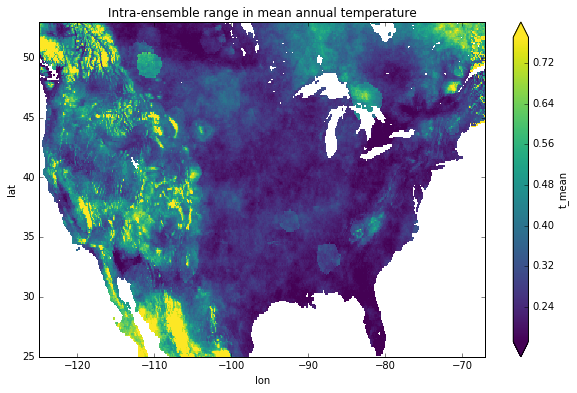

In [16]:
# a quick figure to prove to ourselves we actually did something
out.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

### Persisting data on the cluster

(Make sure you have well over 60GB of RAM on your cluster)

Most of the time spent in the last calculation was loading data from disk.  After we were done with this data, Dask threw it away to free up memory.  If we plan to reuse the same dataset many times then we may want to `persist` it in memory.

In [17]:
t_mean = ds['t_mean']
t_mean = t_mean.persist()
t_mean

<xarray.DataArray 't_mean' (ensemble: 99, time: 12054, lat: 224, lon: 464)>
dask.array<concatenate, shape=(99, 12054, 224, 464), dtype=float64, chunksize=(1, 50, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 -124.4 -124.3 -124.2 ...
  * lat      (lat) float64 25.06 25.19 25.31 25.44 25.56 25.69 25.81 25.94 ...
Dimensions without coordinates: ensemble
Attributes:
    long_name:  Daily estimated mean temperature
    units:      degC

Now the t_mean DataArray is resident in memory on our workers.  We can repeat our computation from last time much more quickly.

In [ ]:
%%time
temp_mean = t_mean.mean(dim='time')
spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
mean = spread.compute()

In [ ]:
mean.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

And we can also modify the computation and try something new.  Keeping data in memory allows to *iterate quickly*, which is the whole point of this exercise.

In [12]:
%%time
temp_mean = t_mean.std(dim='time')
spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
std = spread.compute()

CPU times: user 328 ms, sys: 4 ms, total: 332 ms
Wall time: 4.32 s


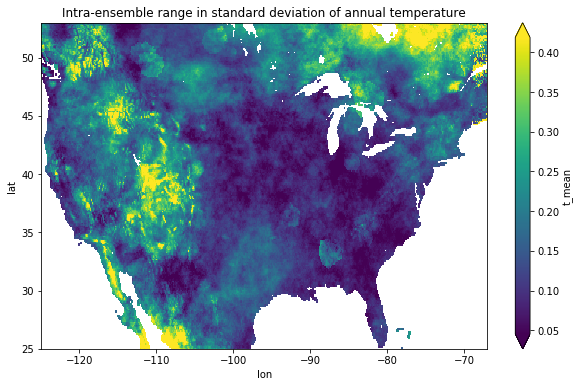

In [13]:
std.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in standard deviation of annual temperature')